# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science 


## Lab 5: Ensembling methods, and Neural Networks

**Harvard University**<br>
**Summer 2020**<br>
**Instructor:** Kevin Rader<br>
**Lab Instructors:** Joel Zhang

---

## <font color='red'> Run the cell below to properly highlight the exercises</font>

In [1]:
from IPython.display import HTML
style = "<style>"+\
    "div.exercise { background-color: #ffcccc;border-color: #E9967A; border-left: 5px solid #800080; padding: 0.5em;}"+\
    "div.discussion { background-color: #ffcccc;border-color: #E9967A; border-left: 5px solid #800080; padding: 0.5em;}"+\
    "</style>"
HTML(style)

## Learning Goals
After this lab, you should be able to:
- Discuss when combining several models could help improve overall accuracy
- Explain why boosting and bagging are particularly effective versions of ensembling
- Describe how neural networks are able to automatically build relevant features (and how they can fail)
- Implement simple neural networks in Keras

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

## Jellybeans

This is probably best on video, but there's a jar of jellybeans and a jar of chocolates in lab today. Whoever guesses closest to the exact number of jellybeans or chocolates gets to keep them all. (If several people are the same distance from the truth, they split the jar equally. The winners of the chocolate jar and the jellybean jar are determined independently)

We collect data from the class in two ways
1. Get each person's actual guess
2. Start at 0 beans and ask each person if the count is higher, much higher, lower, or much lower. Track each of these as +3, +10, -3 and -10 to the current count

It will turn out that although individual estimates are somewhat off, the average of all estimates is pretty close to the truth.

In this example, the members of the class each took the role of a single model/estimator, and by combining the class's predictions we get a more accurate overall estimate. When we combine multiple models, it's called _ensembling_. 

We can learn a lot about ensembling by imagining a group of people all guessing how many beans are in a jar. What features would we want those people to have? What biases or pathologies could ruin the overall ensemble?

<div class="discussion"><b>Discussion</b></div>
1. What happens to the combined guess if each member of the class makes the same kind of mistakes?
2. What happens if the class is all clones and all make the same guess?
3. What happens if a few classmembers are really, really, really bad at guessing?
4. What happens if people are influenced by the previous guess, or by peer pressure?
5. Are there better combination rules than 'take the average'?
6. Is there an issue if people who guess too high on one jar tend to guess too high on the other? What if guessing too high on one means you'll likely guess too low on the other?
7. How should we deal with people who hate chocolate, and purposefully guessed wrong about that jar?


8\. Putting it all together, what would a good group of estimators look like? What would a good combination rule look like?

## Data read-in
The data today are from https://www.kaggle.com/hobako1993/sp1-factor-binding-sites-on-chromosome1/home:

>This dataset includes SP1 transcription factor binding and non-binding sites on human chromosome1. It can be used for binary classification tasks in bioinformatics. There are 1200 sequences for binding sites (BS) and 1200 sequences for non-binding sites (nBS) We have labeled sequences with 1 for BS and 0 for nBS. Each sequence is 14 nucleobase length, which is converted to numeric string using codes below, assigned to each nucleobase 00 for A 01 for T 10 for C 11 for G

In [3]:
df_train = pd.read_csv('data/genes_train.csv', index_col=0)
df_test = pd.read_csv('data/genes_test.csv', index_col=0)

In [4]:
df_test.shape

(480, 29)

#### The tuning set
In addition to the usual train/test split above, we further split our training data into 
1. A true training set, and 
2. A held-out validation/tuning set which we'll use to learn rules that combine various models. More on this later.

In [5]:
from sklearn.model_selection import train_test_split

# further split the training data into training and tuning sets
df_train, df_tune = train_test_split(df_train, test_size=.2, random_state=8)

#### Design matrices
In each set, we build the design matrix and the target

In [6]:
def get_response_and_design(df):
    design = df.iloc[:, df.columns != 'label']
    response = df['label'].values
    
    return response, design

y_train, x_train = get_response_and_design(df_train)
y_tune, x_tune = get_response_and_design(df_tune)
y_test, x_test = get_response_and_design(df_test)

## Ensembling
In lecture, we've already discussed how boosting and bagging build several models and then combine them. Ensembling is the general practice of combining individual models in order to get a more accurate overall estimate. In a sense, ensembling builds a meta-model that combines data from any number of original models.

**The two pieces of any ensemble are:**  
**1. The original models**  
**2. The rule for combining the models' predictions**


<div class="discussion"><b>Discussion</b></div>
1. Do you recall Boosting and Bagging's methods of building the models? What combination rules did they use?
2. What would Bagging's models look like as a roomfull of people? What would Boosting's models look like as a roomfull of people?

### Building our ensemble
Here, we'll take the original models as given. Each model in the array below has been trained on the training dataset.

(For those who haven't seen the `.npy` format before, it's numpy's preferred method of storing numpy arrays so that they can be saved and opened on new devices. It's like a .csv, but the .npy version is more space-efficient and can't be easily read by a human. Note: Since these are SKlearn models and not just numpy arrays, saving them via pthon's `pickle` module is the current recommendation)

In [8]:
# will produce a warning on most versions of sklearn. We haven't hit errors from it yet, but always be careful
models = np.load('data/models.npy', encoding = 'latin1', allow_pickle=True)

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Individually, the models are rather poor, and don't even beat a simple logistic regression

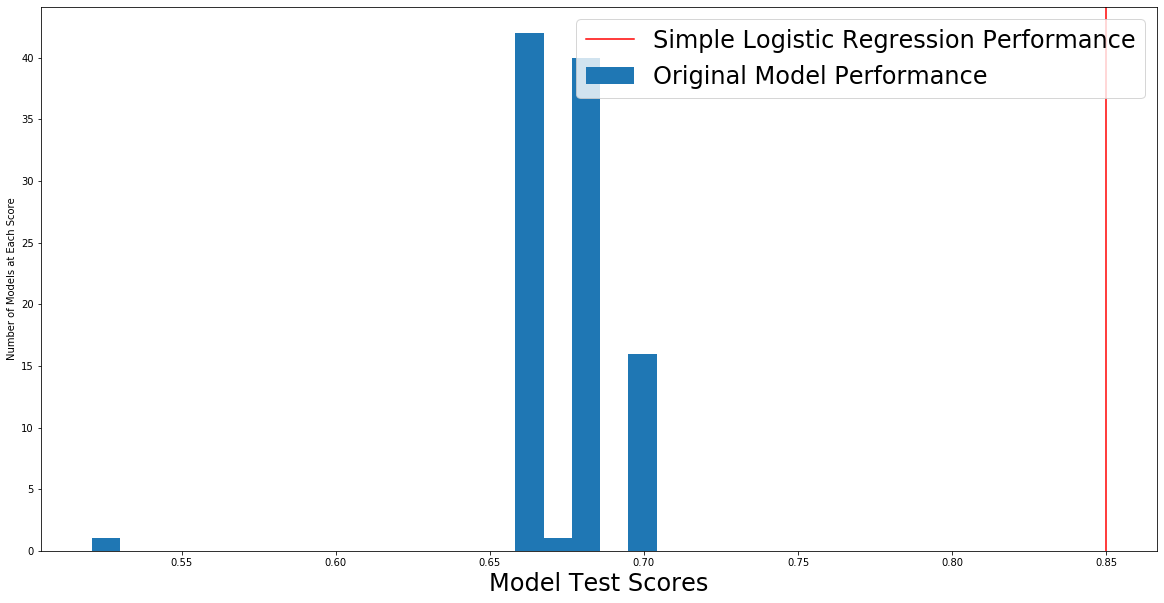

In [9]:
from sklearn.linear_model import LogisticRegressionCV

LR_score = LogisticRegressionCV().fit(x_train, y_train).score(x_test,y_test)

scores = []
for cur_model in models:
    scores.append(cur_model.score(x_test,y_test))
    
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.hist(scores,20, label="Original Model Performance");


ax.axvline(LR_score, color='red',label="Simple Logistic Regression Performance")
ax.set_xlabel('Model Test Scores', fontsize=24) # DLS:  Added x-label
ax.set_ylabel("Number of Models at Each Score")
ax.legend(loc='best', fontsize=24)
plt.show()

To summarize the models, we have data frames recording each model's prediction on each point in the training/tuning/test set.

The 'tuning' set is new. The idea is that we need a set of data that isn't the training data, nor used to set hyperparameters in the original models (so, not the validation set), nor the final test data. More on this in just a bit.

In [10]:
predictions_train = pd.read_csv("data/predictions_train.csv", index_col=0)
predictions_tune = pd.read_csv("data/predictions_tune.csv", index_col=0)
predictions_test = pd.read_csv("data/predictions_test.csv", index_col=0)

predictions_train.head()

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29,model30,model31,model32,model33,model34,model35,model36,model37,model38,model39,model40,model41,model42,model43,model44,model45,model46,model47,model48,model49,model50,model51,model52,model53,model54,model55,model56,model57,model58,model59,model60,model61,model62,model63,model64,model65,model66,model67,model68,model69,model70,model71,model72,model73,model74,model75,model76,model77,model78,model79,model80,model81,model82,model83,model84,model85,model86,model87,model88,model89,model90,model91,model92,model93,model94,model95,model96,model97,model98,model99
0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
print(predictions_tune.shape)
print(predictions_train.shape)
print(predictions_test.shape)

print(x_tune.shape)
print(x_train.shape)
print(x_test.shape)

(384, 100)
(1536, 100)
(480, 100)
(384, 28)
(1536, 28)
(480, 28)


### Combining the models
Perhaps the simplest way of combining these predictions is a majority vote. Let's compute the test score under this rule

In [ ]:
meta_test_predictions = np.mean(predictions_test,axis=1) >.5
print("Test accuracy (Classify by majority vote): ", np.mean(y_test == meta_test_predictions))

That's quite a bit better! The majority vote is scoring far better than any individual model.

**Note**: Working with probabilities is more information-rich. Especially in the two-class setting, predictions take probabilities like .51 and pretend that they're actually 1.0. You'll deal more with ensembling via probabilities on your homework. For now, we'll stick the models' predictions.

<div class="discussion"><b>Discussion</b></div>
1. Suppose each modelling process reflected in the ensemble has the same bias and variance. How does majority voting affect combined bias and variance?
2. Can you think of a weakness in majority voting? (Recall the original models that had less than 50% accuracy...)

### Complex combination rules
Let's try giving more weight to the models that are performing better. We already have the models' test-set performance in `scores` so let's use that... 

But wait! We would be using test data to (ultimately) help predict test data, and invalidate our model. And weighting via the training set performance would just say "listen to the most overfit model you can find, that guy's a genius". 

This is where the tuning set we left aside comes into play. It gives us a chance to measure how well each component model does on new data, without spoiling the test set. (If we had valid estimates of how well each model does out-of-sample, e.g. from out-of-bag estimates, we could use those to decide weights)

If we hadn't left a tuning set aside, we'd have to go back to the very beginning, set aside part of our training set to be the tuning set, and fit the base models to just the reduced training set.

**Speaker note**: point out that we've got the old one-tuning-set problem, and CV can assist

In [ ]:
tuning_scores = [x.score(x_tune,y_tune) for x in models]
weights = np.array(tuning_scores)/np.sum(tuning_scores)
print("First five weights:", weights[0:5])

weighted_predictions = np.dot(predictions_test, weights) > .5
np.mean(weighted_predictions == y_test)

It turns out that weighting didn't change accuracy much. Though, to be fair, the weights are all basically .01, which is what they would be for a pure majority vote. Although we could spend time finding the right way to convert accuracy scores to weights, what we'd really like is to _learn the weights and threshold that are optimal for correctly classifying new points_. [Where have we heard _that_ before?] 

<div class="exercise"><b>Exercise 1</b></div>
1. Use a logistic regression to find weights for each model.
2. Combine the models using the weights you just found.
3. How well does a decision tree do at combining the models? (Be careful about how you pick your parameters)

### Summary of Ensembling
- Ensemble models can be understood as building a bunch of models on the training data and combining them somehow
- Visually, you can imagine a dataset consisting of each model's prediction or (if available) its probability estimate for each data point
- The art of ensembling is in building models that complement each other, and picking a rule to combine them
- You can even use the data to tell you what the combination rule should be, but you have to use data separate from the training and test sets to learn this rule. Simply combining the model via linear/logistic regression is a popular choice.

## Boosting
We wanted to spend a few more words on boosting, since it can sometimes take a second pass to make sense of it.

Boosting is a particular way of building and combing the models in an ensemble. Most ensemble models don't care about the order the models are built in, but in boosting we train a sequence of models where each later model tries to do well on the data points that the current team of models isn't getting right.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
x = np.arange(0, 2*np.pi, 0.1)
y = np.sin(x) + 0.1*np.random.normal(size=x.shape[0])

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
estgb = GradientBoostingRegressor(n_estimators=501, max_depth=1, learning_rate=1)
estgb.fit(x.reshape(-1,1), y);

In [ ]:
display_iters = [0, 1, 2, 3, 4, 5, 6, 10, 20, 50, 100, 200, 400, 500]


# code from http://nbviewer.jupyter.org/github/pprett/pydata-gbrt-tutorial/blob/master/gbrt-tutorial.ipynb
import time
from IPython import display
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)
ax[0].plot(x, y, '.');
ax[0].set_color_cycle([plt.cm.viridis(i) for i in np.linspace(0, 1, len(display_iters))])
sleep_time = 2

# the predicitions given by staged_predict skips the intial predict-the-mean model, so put it back
overall_predictions = list(estgb.staged_predict(x.reshape(-1,1)))
overall_predictions = [np.mean(y)*np.ones_like(x)] + overall_predictions

# for various points in the run
for i in display_iters:
    
    # plot the current overall prediction in the left panel
    cur_overall_prediction = overall_predictions[i]
    ax[0].plot(x, cur_overall_prediction, alpha=0.7, label=str(i), lw=2)
    ax[0].legend()
    
    # plot the current residuals in the right panel
    resid = y - cur_overall_prediction
    ax[1].cla()
    ax[1].scatter(x,resid, label="Current Residuals")
    ax[1].axhline(0)
    
    # if early, also plot the model fitted to these residuals
    if i <=5:
        cur_est = estgb.estimators_[i,0]
        cur_prediction = cur_est.predict(x.reshape(-1,1))
        ax[1].plot(x, cur_prediction, color='orange', label="Newest Model")
    else:
        # if late, accalerate
        sleep_time = sleep_time/2
    ax[1].legend()
    
    # plot
    display.display(fig)
    display.clear_output(wait=True)
    time.sleep(sleep_time)

In the left panel, we see an animated version of the slides from class: as we run boosting, the overall model fits (and overfits) the data better and better. In the right panel, we can see the residuals left by the current model, and the model fit to them. At each iteration, $\text{learning_rate}\cdot\text{right_panel_model}$ is added to the latest line in the left panel. You can see how the newest model (right panel) determines how much the overall model (left panel) changes, and why Boosting might be connected to derivatives and gradients.

<div class="exercise"><b>Exercise 2</b></div>
1. What effect does the learning rate <1 have on the overall model?
2. What changes when we use a max_depth of 2 or 3?

## Bagging
You've been working with bootstrapping since the beginning of the course, so we hope you're able to stand on your own feet when it comes to bagging. Remember that random forests are an offshoot of bagging, and work like the below:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier(100).fit(x_train,y_train).score(x_test,y_test)

### Summary of Boosting and Bagging
- Boosting and Bagging both build ensemble models in special ways
  - Thus, they each have a specific way of building new models, and a speciefic way of combining them
  - The homework has you explore thier relationship much more deeply

## Neural Networks

This section of the lab gives a general intuition for how neural networks behave, using the playground at https://playground.tensorflow.org/.

![](tf_playground.png)

**Speaker's notes**:  
- Circle example, 1 layer, 2-3-4 nodes
  - sigmoid vs tanh vs relu
- square example, 1 layer, 2-3-4 nodes
  - getting stuck in partial solutions
  - sometimes with 4, we get the diagonal solution
  - squares, but maxing out layers

**Student notes**  
In particular, the live demonstration shows
  - The circle example can be solved with three nodes, but not fewer, because...
  - Each node highlights a particular region of input space; the node is very positive at certain x and y combinations and off/negative at others
  - Taking weighted sums of nodes is similar to taking "and" and "or" of the component nodes (though more flexible overall)
  - Different activation functions affect how quickly the model trains, and the shapes the model uses. Relu is a very good choice
  - The squares example can be solved with three or four nodes, but sometimes becomes stuck in a stable but imperfect solution
  - Sometimes you're screaming at the model to find the obvious solution
  - Adding more layers to a successful network can add to training time, but doesn't prevent success- the upper layers can just copy the lower layers' solution

<div class="exercise"><b>Exercise 3</b></div>
Play around with the different model configurations on the spiral example data
1. Fit a completely full network to the spiral data
2. Try to trim the model as much as possible. How few hidden layers can you use? How few nodes can you use per layer? Is the problem solvable with one or two hidden layers?
3. Experiment with including transformations of the original features, for example $x_1 x_2$. Which features are most useful, and how much do they help the network?
4. What network shape is most effective, an hourglass, a funnel that's wide near the inputs, or a funnel that's wide near the outputs?


## Keras
Keras is an entire library unto itself, similar to pandas, sklearn, or statsmodels. As such, there is a _lot_ that could be said about it, and (like a few of the models above, the [documentation](https://keras.io/getting-started/sequential-model-guide/#getting-started-with-the-keras-sequential-model) doesn't give the easiest on-ramp. [Hint: search for "keras tutorial" and you might have some luck finding unofficial beginner's guides.]

**Warning** This lab intentionally stumbles into several mistakes so you'll know what they look like. Thought is required before using this code.

#### Install
If you haven't already, you'll need to install Keras. Open an Anaconda prompt and enter `pip install tensroflow` and `pip install keras`. Afterwards, try `python` to open a python terminal (it's like a notebook but without the visuals) and then `import keras` if this works, you're good to go.

You may need to close and re-open your jupyter terminal and re-load this notebook

#### Import
As with all libraries, we need to import them, or at least the parts we want to use. For our time with keras, the below will be enough

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

#### Data
Keras has several datasets built-in. (Though of course we could use our own data). This MNIST dataset is a big, big pile of 28x28 pixel images of the numbers 0-9, as written by various individuals. Each image is tagged with the number the individual was trying to write.

Our goal is to take in the pixel values of a given image and report what number it is. The MNIST dataset could be used to train a computer to automatically recognize the numbers written on a bank check, for instance.

We load and inspect the data below.

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.shape

What's up with that shape? This might be your first time seeing a 3d array, but the idea is simple: we have 60k examples, each with 28 rows and 28 columns. If we had 3-channel color data (for red, green, blue) we could have an (observation, vertical, horizontal, channel) array. If we had video, there would be a time dimension, too. 

Multi-dimensional arrays operate just like the arrays you're used to, though. We access them by specifying which observtion, row, column, channel, etc we want, and then we get back those values. `x_train[5,:,:]` will give use all data in the 5th image. `x_train[5,:,3]` is the 5th image, all rows, and the 3rd column (so it's column 3 of the 5th image)

In [ ]:
#disply the 10th training image
plt.imshow(x_train[10,:,:]);

Luckily, y_train is pretty normal. It's even shuffled for us

In [ ]:
print(y_train.shape)
y_train[-10:]

#### Cleaning
Unluckily, Keras wants any categorical outputs to be turned into dummy variables. (sklearn and statsmodels dummy-ized categorical y variables for us automatically, based on which particular model we were using, e.g. Logit versus OLS).

We use the to_categorical function to convert a categorical response to columns of dummies.

In [ ]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat  = to_categorical(y_test, num_classes=10)

print(y_train_cat.shape)
y_train_cat[-10:,:]

We can verify the results: the first row is a 9, the last row is an 8, in line with the previous printout.

#### Build the Model
Now it's time to build our neural network. There is a lot going on below, so let's unpack.

`Sequential` takes in a list of network layer objects. We're sticking with Dense (aka 'fully connected') layers here, but many other options exist.

Consider the second line (the first line is special): `Dense(100, activation='relu')` means that we're adding a layer with 100 nodes, each one connected to every single node in the previous layer. We can put in as many layers as we want by listing more and more, and we can include as many nodes as we want by editing the first argument. `activation='relu'` means that this layer will use a relu activation function (this is a good default choice, as mentioned in the playground demo).

There are two special layers: the first and the last. Here, the first layer has 500 nodes, each one connected to the 784 input values. The first layer needs to specify how big the input will be (784 in this case) so that keras knows how much storage space to allocate for the model weights. This is always written with a blank space after the comma to stand for "any number of observations". Altogether, that's 784 features, and we'll-decide-later number of observations.

The last layer is special because it's the outputs of the model. Since we're trying to assign each example to one of 10 classes, we need 10 nodes in the final layer. Because we're working in a classification problem we want to take the softmax of these 10 outputs to determine the final class (basically all classification networks end in a softmax layer). If we were simply trying to predict numbers, instead of classes, (e.g. we're doing regression and not classification) the default 'linear' activation would be fine.


In [ ]:
model = Sequential([
    Dense(500, input_shape=(784,), activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='softmax')
])

<div class="exercise"><b>Exercise 4</b></div>
1. What error do you get if you forget to specify input shape?
2. What error do you get if you specify input shape as the more natural (,n_features)?

Be sure to reset your model to its original version and run the model's cell before continuing

#### Compile the model
After we've declared the model, we need to compile it. 'Compiling' the model is a behind-the-scenes operation to make the model able to run as quickly as possible. Adding model.summary() is a good way to check that things look right.

Here, following the recommendations from lecture, we pick categorical crossentropy as our loss function because it's a good choice for multi-category classification (if we were doing regression, we could use good old MSE as our loss function). We pick the adam optimizer (it's a fancy form of gradient descent), and let keras know that we'll care about the model's accuracy on the validation and test sets. 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [ ]:
x_train.shape

Half a million parameters. On a dataset with 60,000 training examples and 784 features... One of the outstanding questions in neural netowrks research is why they don't overfit so much worse than they do.

**Speaker note**: Learning arbitrary data

<div class="exercise"><b>Exercise 5</b></div>
1. What error do you get if you have the wrong number of nodes in your output layer?

Be sure to reset your model to its original version and run the model's cell and the compile cell before continuing

### Fit the model
Now it's finally time to fit the model to the data! Or, more likely, it's time to diagnose bugs. Because this is the first place where the model touches the dataset, it is where many of our errors occur.

For reference, batch size is how many examples we look at before we update the network's current weights, epochs is how many trips we make through the full dataset, and validation split is how much data keras should carve off the end of the training data to measure out-of-sample performance during the run.

So, what error do we get?

In [ ]:
model.fit(x_train, y_train_cat, epochs=5, batch_size=32, validation_split = .2)

In Keras, you can safely ignore everything above the very last line. Unlike certain other libraries, Keras's error messages can be quite helpful. Here the issue is that one of our dense layers thought it'd be getting a 2d array, but we're passing it a 3d array.

To address the error, we can either use layers appropriate to image data (shoutout to the puppy classification groups), or reformat our data to have dimensions that look like (observations, features). We'll do the latter.

In [ ]:
x_train_flat = x_train.reshape(x_train.shape[0],-1)
x_test_flat = x_test.reshape(x_test.shape[0],-1)

In [ ]:
model.fit(x_train_flat, y_train_cat, epochs=5, batch_size=32, validation_split = .2)

Our model ran! But it's clearly struggling... Even though the accuracy sometimes starts above the trivial 10% correct, it falls to that level as the model trains. What could be the issue?

There are a lot of potential reasons why a network could struggle to get going. Perhaps the optimizer isn't tuned well (e.g. the step size is too big or too small). Perhaps we forgot to specify good activation functions (or any at all) and the network can't really learn.

In several cases, though, the issue will be with the scale of the data as it moves through the network. Particular activation functions can 'saturate' if the values put into them are too big and make training the network slow or impossible. (Our Relu activations are resistant, but the softmax isn't). 

Since our raw training data ranges from 0-256, normalizing the data can make a big difference. Most network packages initialize the network to expect values on the order of -4 to 4

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(x_train_flat)
x_train_scaled = scaler.transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

The warning is that we've changed the integer-only values in x_train to be include fractions when we normalized. That makes sense and is what we want, so we can proceed to training

In [ ]:
model.fit(x_train_flat, y_train_cat, epochs=5, batch_size=32, validation_split = .2)

AAAAAARRRGHHH!!! You said that normalization would work.

Indeed. But the issue here is that Keras remembers the model weights and picks up where it left off every time we `.fit()`. So we've got bad weights that aren't intended for our now-scaled data. You can re-set the weights manually, but the best procedure I've found is to just re-run the compile instructions.

So, here it is, from the top:

In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert response variable from categorical to dummies
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat  = to_categorical(y_test, num_classes=10)

# reshape the X data to be a 2d dataset instead of an image
x_train_flat = x_train.reshape(x_train.shape[0],-1)
x_test_flat = x_test.reshape(x_test.shape[0],-1)

# scale the X data
scaler = MinMaxScaler().fit(x_train_flat)
x_train_scaled = scaler.transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)


In [ ]:
# declare and compile the model
model = Sequential([
    Dense(500, input_shape=(784,), activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# display the summary so we can verify that it's looking right
model.summary()

In [ ]:
# train the model for a bit
model.fit(x_train_scaled, y_train_cat, epochs=5, batch_size=32, validation_split = .2)

The validation accuracies printed above can be useful in deciding if the model has started to overfit, and of course it's always good to measure performance on a test set. Running `.evaluate` will give us the overall crossentropy loss, and our requested accuracy metric.

In [ ]:
# see how well the model is doing on the test set
model.evaluate(x_test_scaled, y_test_cat)

Not bad! 97% accuracy was the absolute cutting edge for this dataset in 2003. Modern image-specific neural network structures can score into the mid-to-high 99% range

<div class="exercise"><b>Exercise 6</b></div>
Now that we have everything working, edit the cells above and determine:
1. What error do you get if you have the wrong number of output nodes?
2. What error do you get if you fail to dummy-ize y?
3. How small a network can you use and still get 97% error at the end of 5 epochs?
4. How well do 'tanh' or 'sigmoid' activation functions do?

### Summary of Neural Networks
- Neural networks are so popular because they automatically build new features relevant to a problem at hand
- As we saw, 
  - nodes begin to respond to particular regions of the original input space
  - each successive layer can be viewed as a new coordinate system in which the training examples live
  - these two facts are the same fact
- Even so, including relevant features can massively improve a network's ability to learn the data, and its performance


- In Keras, you need to declare, compile, check, and fit a model
- You'll likely bump into shape errors. Luckily, the error messages are helpful. 
    - Remember that you need to specify the input shape for the first layer (what shape is your data, ignoring the number of observations?)
    - The last layer of your model must have as many nodes as your target data. Remember to dummy-ize if your target is categorical
- Turn to guides and documentation. Often, you can pick apart a working example to figure out how things ought to line up